1. Loading all neccessary packages for the visualisation of image and for Mask2Former to run

In [ ]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import transformers
import cv2
import os

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

print(cv2.getBuildInformation())

2. Loading the auto image process (AIP) and the Mask2Former (M2F) Image Segmentation model from the Transformers library. 
The Transformers library provides API and tools for users to deploy, train and use models from Huggingface's huge collection of pre-trained models. This is so users do not have to build and train them from the ground up, which is a great convenience. 

In [ ]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-cityscapes-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-cityscapes-panoptic")

3. Optional: You can cache the AIP and the M2F model locally in case of bad Internet connections. Change the directories accordingly. 

In [ ]:
processor.save_pretrained("/Users/siwei/pytorch-test/env/mask2former") # caching the mask2former tokenizer to be used offline
model.save_pretrained("/Users/siwei/pytorch-test/env/mask2former") # caching the mask2former model to be used offline 

4. Optional: You can load the cached AIP and M2F from the specified directory.

In [3]:
#Now when you’re offline, reload your files with PreTrainedModel.from_pretrained() from the specified directory:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
processor = AutoImageProcessor.from_pretrained("/Users/siwei/pytorch-test/env/mask2former")
model = Mask2FormerForUniversalSegmentation.from_pretrained("/Users/siwei/pytorch-test/env/mask2former")

5. Using PIL to open an image. Change the directory to check out an image for yourself.

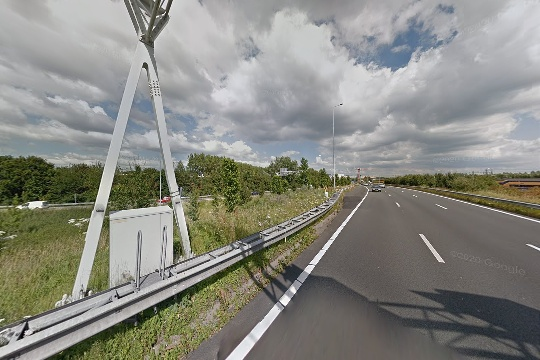

In [13]:
from PIL import Image
import requests

image = Image.open("/Users/siwei/Desktop/3600_svi/2135_4.842361393100000_52.338400389699999_201407.jpg120.jpg")

display(image)

6. Defines the function to draw an Image Segmentation mask of a singular image. This demonstrates how the M2F model work from a visual standpoint.

In [11]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def draw_panoptic_segmentation(filename):

    inputs = processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
    
        # Model predicts class_queries_logits of shape `(batch_size, num_queries)`
        # and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
        class_queries_logits = outputs.class_queries_logits
        masks_queries_logits = outputs.masks_queries_logits

    result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    segmentation = result['segmentation']
    segments_info = result['segments_info']

    
    
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.title.set_text(filename)
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    ax.legend(handles=handles)

7. Change directory to your own image to display the segmentation.

`label_ids_to_fuse` unset. No instance will be fused.
/var/folders/15/5fpdmgmn4vs9s77smzmh2q800000gn/T/ipykernel_51992/3351591260.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


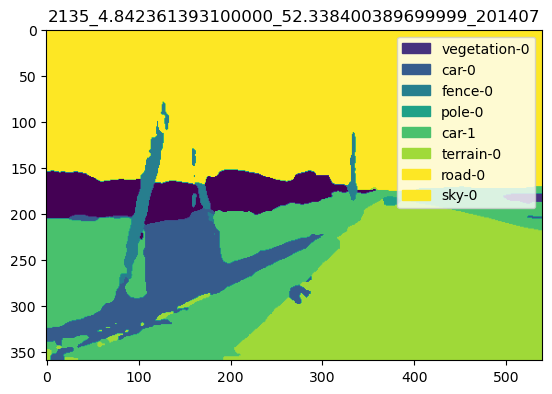

In [12]:
  draw_panoptic_segmentation('2135_4.842361393100000_52.338400389699999_201407')

8. This shows all the classes of objects M2F is trained to recognize (This specific variant trained on Cityscape dataset).

In [14]:
model.config.id2label # all the objects the model is trained to recognize

{0: 'road',
 1: 'sidewalk',
 2: 'building',
 3: 'wall',
 4: 'fence',
 5: 'pole',
 6: 'traffic light',
 7: 'traffic sign',
 8: 'vegetation',
 9: 'terrain',
 10: 'sky',
 11: 'person',
 12: 'rider',
 13: 'car',
 14: 'truck',
 15: 'bus',
 16: 'train',
 17: 'motorcycle',
 18: 'bicycle'}

9. Creating the image dataset. change the 'svi_3k6' variable to point to the directory for the images on your device.
The dataset is the format of a list of dictionaries. Each dict contains a filename and corresponding image.

In [21]:
import os
from PIL import Image

svi_3k6 = '/Users/siwei/Desktop/3600_svi' ##path for the 3600 street view images, replace this with your own file path 

image_files = [file for file in os.listdir(svi_3k6) if file.endswith(('.png', '.jpg', '.jpeg'))] #extract all file names
images = []


for file in image_files:
        img = Image.open(os.path.join(svi_3k6, file)) # opens an image 
        images.append({'filename':file, 'img':img}) # each dict contains the filename and the corresponding image 





10. Optional: Breaking the image dataset into smaller chunks with 500 images each, so we can process it one at a time. This is due to my device's RAM limitations. If you have a more powerful device then skip this step and use the original dataset.

In [29]:
small_500 = images[0:500] # First 500 images 
small_1000 = images[500:1000]
small_1500 = images[1000:1500]
small_2000 = images[1500:2000]
small_2500 = images[2000:2500]
small_3000 = images[2500:3000]
small_3500 = images[3000:3500]
small_rest = images[3500:3600]

11. Defines the function that take the image dataset and M2F processes over them one by one. Returns image segmentation results.

In [ ]:
def classify_imgs(images_dataset):

  rs = []


  processor = AutoImageProcessor.from_pretrained("/Users/siwei/pytorch-test/env/mask2former")
  model = Mask2FormerForUniversalSegmentation.from_pretrained("/Users/siwei/pytorch-test/env/mask2former")

  for img in images_dataset:

    inputs = processor(images=img['img'], return_tensors="pt")

    with torch.no_grad():
      outputs = model(**inputs)

      class_queries_logits = outputs.class_queries_logits
      masks_queries_logits = outputs.masks_queries_logits

    result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[img['img'].size[::-1]])[0]
    segmentation = result['segmentation'].tolist()
    segments_info = result['segments_info']
    rs.append({'filename':img['filename'],'segmentaion':segmentation, 'segments_info': segments_info})

  return rs


In [ ]:
result = classify_imgs(small_rest)

12. Converts the image segmentation results into json so they can be processed analysed later in Results_processing.ipynb

In [78]:
import json


json_string = json.dumps(result) ## Manually change the param to rs1 rs2 rs3 rs4 etc to convert them all to json

# Write the JSON string to a file
with open('/Users/siwei/Desktop/small_rest.json', 'w') as file:
    file.write(json_string)